In [29]:


import csv
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt  
from ipywidgets import interact, FloatSlider
from datetime import datetime
import pandas as pd
import os

# Imports supplémentaires pour Fourier et résidus
from scipy.optimize import curve_fit
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.interpolate import BSpline
import seaborn as sns
from scipy.linalg import lstsq
from scipy.stats import pearsonr
import importlib
import function
importlib.reload(function)
from function import *

Série : VV_ASC  |  ROI index : 0  |  n = 243
Sélection du nombre de nœuds (alpha=3.0) ...

   # nœuds   p=nœuds+4             RSS              Cp
  ------------------------------------------------------
        81          85          6.7102         17.5399  ← modèle initial
        80          84          6.4634         17.1657  ← optimal
        79          83          6.4880         17.0629  ← optimal
        78          82          6.4666         16.9141  ← optimal
        77          81          6.3582         16.6783  ← optimal
        76          80          6.6491         16.8418
        75          79          6.7102         16.7755
        74          78          7.0285         16.9664
        73          77          7.2150         17.0255
        72          76          6.8869         16.5700  ← optimal
        71          75          6.9311         16.4868  ← optimal
        70          74          6.8820         16.3102  ← optimal
        69          73          6.7206    

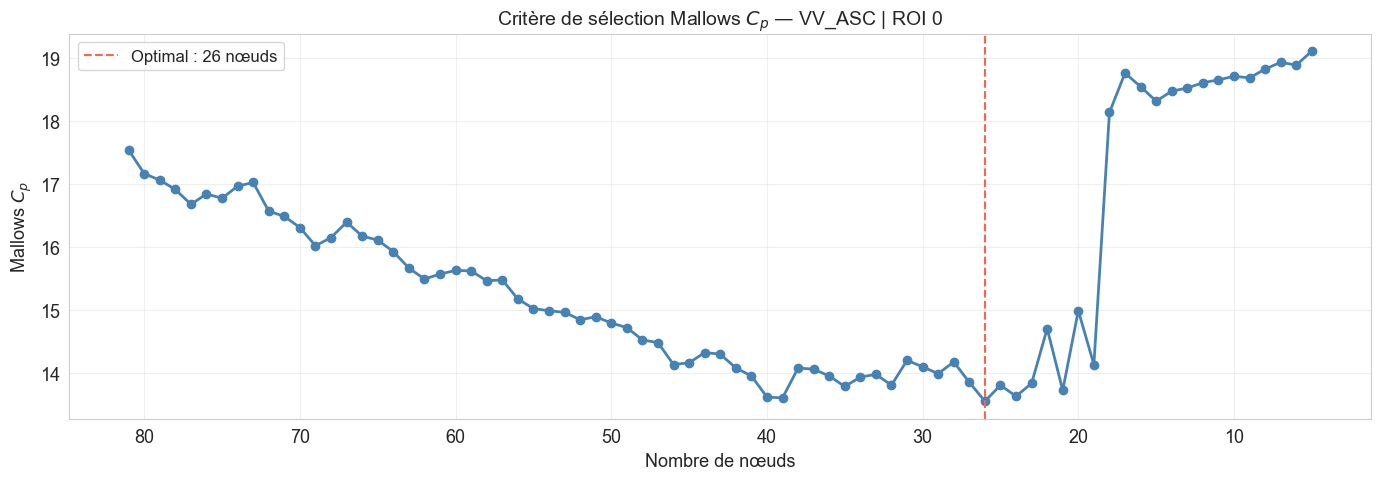

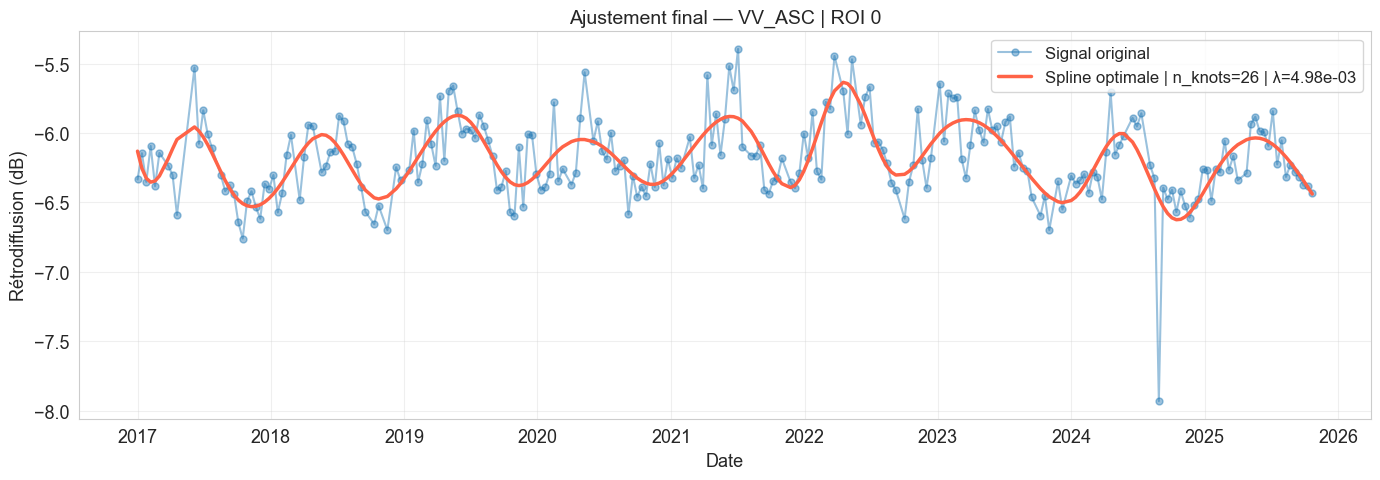

In [24]:
# ════════════════════════════════════════════════════════════
#  PARAMÈTRES — à modifier ici uniquement
# ════════════════════════════════════════════════════════════

series_to_plot = "VV_ASC"        # "VV_ASC" | "VH_ASC" | "VV_DSC" | "VH_DSC"
roi_index      = 0                # index de la ROI
value_source,date_source, dfs_raw   = prepadataframe(1,1)   
alpha          = 3.0              # paramètre Mallows Cp (3=Kooperberg, 2=AIC, log(n)=BIC)

# ════════════════════════════════════════════════════════════
#  PRÉPARATION DES DONNÉES
# ════════════════════════════════════════════════════════════

dates = pd.to_datetime(date_source[series_to_plot])
values_array = value_source[series_to_plot]
if values_array.ndim == 1:
    values_array = values_array[:, np.newaxis]
roi_idx = min(roi_index, values_array.shape[1] - 1)
values = values_array[:, roi_idx]

t_numeric = np.array([(d - dates[0]).days for d in dates], dtype=float)

print(f"Série : {series_to_plot}  |  ROI index : {roi_idx}  |  n = {len(values)}")
print(f"Sélection du nombre de nœuds (alpha={alpha}) ...\n")
n_knots_optimal, history = stepwise_knot_selection_bspline(t_numeric, values, alpha=alpha)

# ════════════════════════════════════════════════════════════
#  AJUSTEMENT FINAL
# ════════════════════════════════════════════════════════════

B        = build_bspline_basis(t_numeric, n_knots_optimal)
lam_opt  = optimize_lambda_gcv(B, values)
_, Y_hat = penalized_spline_fit(B, values, lam_opt) ### la spline

# ════════════════════════════════════════════════════════════
#  VISUALISATION — graphe 1 : critère Cp
# ════════════════════════════════════════════════════════════

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 13, "axes.titlesize": 14, "legend.fontsize": 12})

plt.figure(figsize=(14, 5))
plt.plot(history["n_knots"], history["Cp"], "o-", color="steelblue", linewidth=2)
plt.axvline(n_knots_optimal, color="tomato", linestyle="--",
            label=f"Optimal : {n_knots_optimal} nœuds")
plt.xlabel("Nombre de nœuds")
plt.ylabel("Mallows $C_p$")
plt.title(f"Critère de sélection Mallows $C_p$ — {series_to_plot} | ROI {roi_idx}")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ════════════════════════════════════════════════════════════
#  VISUALISATION — graphe 2 : ajustement final
# ════════════════════════════════════════════════════════════

plt.figure(figsize=(14, 5))
plt.plot(dates, values, '-o', color='tab:blue', alpha=0.45,
         linewidth=1.5, markersize=5, label="Signal original")
plt.plot(dates, Y_hat, color='tomato', linewidth=2.5,
         label=f"Spline optimale | n_knots={n_knots_optimal} | λ={lam_opt:.2e}")
plt.xlabel("Date")
plt.ylabel("Rétrodiffusion (dB)")
plt.title(f"Ajustement final — {series_to_plot} | ROI {roi_idx}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

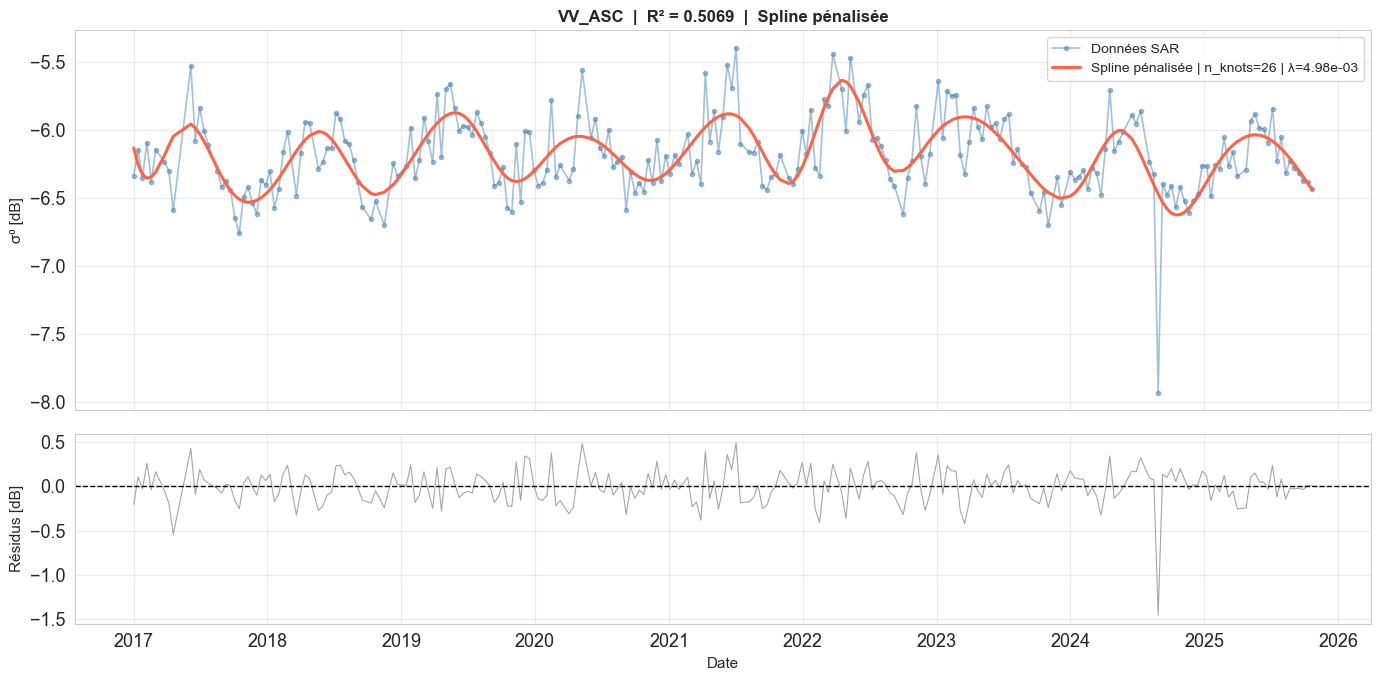

    → spline_fit_VV_ASC_k26.png


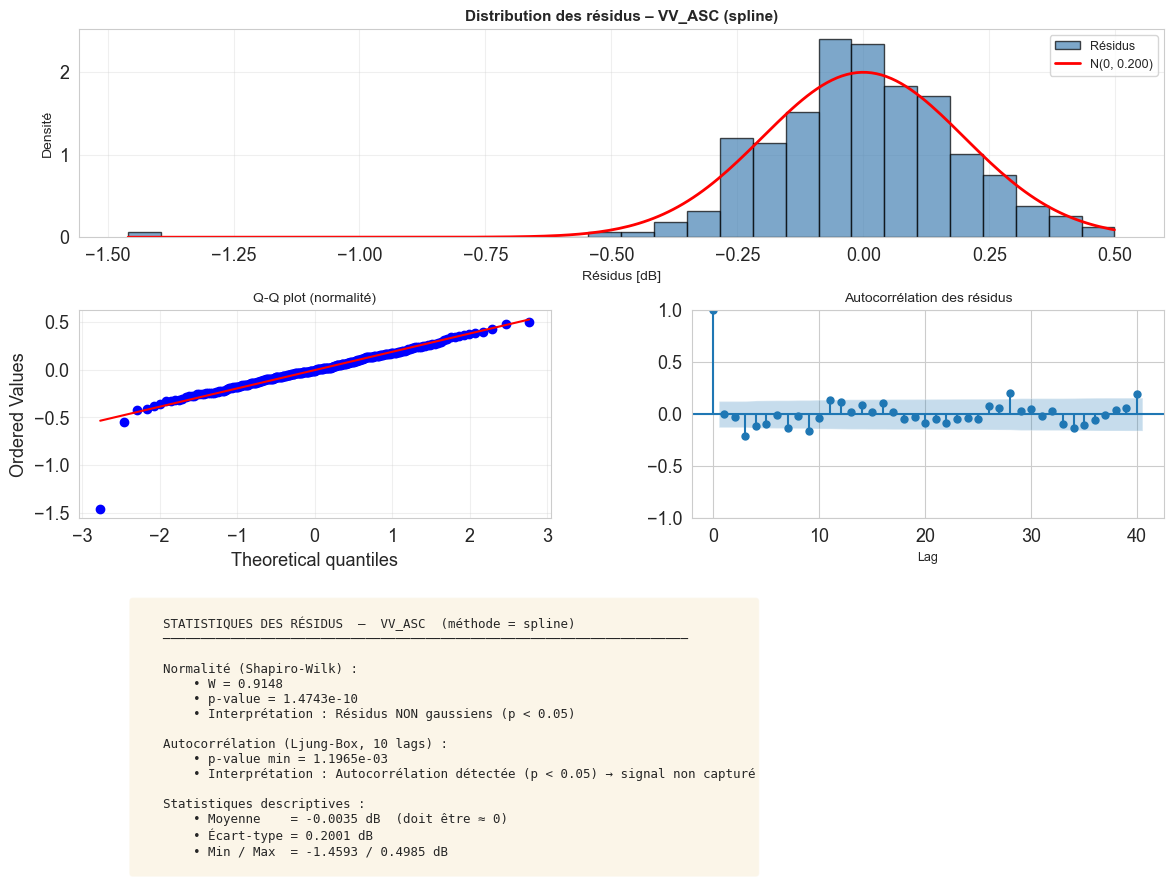

    → residuals_analysis_VV_ASC_méthodespline.png


In [36]:


# Spline pénalisée
residuals_spline, r2 = plot_spline_fit(
    t_numeric, values, Y_hat, dates, 
    nom=series_to_plot, 
    n_knots=n_knots_optimal, 
    lam=lam_opt
)

analyze_residuals(residuals_spline, series_to_plot, method="spline")
residuals_spline = values - Y_hat


In [33]:
def plot_spline_fit(t, values, Y_hat, dates, nom, n_knots, lam, outdir="figures_spline"):
    """Visualise le signal, le fit spline pénalisé et les résidus."""
    os.makedirs(outdir, exist_ok=True)
    
    residuals = values - Y_hat
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True,
                              gridspec_kw={"height_ratios": [2, 1]})
    
    # ── Signal + spline ───────────────────────────────────────────────────
    ax = axes[0]
    ax.plot(dates, values, "-o", lw=1.2, alpha=0.5, markersize=3,
            label="Données SAR", color="steelblue")
    ax.plot(dates, Y_hat, "-", lw=2.2,
            label=f"Spline pénalisée | n_knots={n_knots} | λ={lam:.2e}",
            color="tomato")
    ax.set_ylabel("σ⁰ [dB]", fontsize=11)
    ax.legend(loc="best", fontsize=10)
    ax.grid(True, alpha=0.4)
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - values.mean())**2)
    r2 = 1 - ss_res / ss_tot
    ax.set_title(f"{nom}  |  R² = {r2:.4f}  |  Spline pénalisée", fontsize=12, fontweight="bold")
    
    # ── Résidus ───────────────────────────────────────────────────────────
    ax = axes[1]
    ax.plot(dates, residuals, "-", lw=0.8, alpha=0.7, color="gray")
    ax.axhline(0, color="black", linestyle="--", lw=1)
    ax.set_ylabel("Résidus [dB]", fontsize=11)
    ax.set_xlabel("Date", fontsize=11)
    ax.grid(True, alpha=0.4)
    
    plt.tight_layout()
    fname = f"spline_fit_{nom}_k{n_knots}.png"
    plt.savefig(os.path.join(outdir, fname), dpi=150, bbox_inches="tight")
    plt.show()
    print(f"    → {fname}")
    
    return residuals, r2